# Unconstraining Demand Using Expectation-Maximization (EM) Algorithm

The expectation-maximization (EM) method is the most widely used method for correcting for constrained demand data in quantity-based revenue management. The goal of implementing EM method is to find parameters of an underlying demand distribution for those observations.

Reference: https://www.jstor.org/stable/2984875#metadata_info_tab_contents

Reference: https://www.youtube.com/watch?v=REypj2sy_5U&list=PLBv09BD7ez_4e9LtmK626Evn1ion6ynrt

In [1]:
%matplotlib inline

In [2]:
# Importing required Python libraries
# math: Provides functions for mathematical operations
# numpy: Provides support for arrays and matrices, along with high-level mathematical functions to operate on these
# pandas: Provides data manipulation and analysis capabilities
# matplotlib.pyplot: Provides plotting capabilities
# scipy.stats: Provides a large number of probability distributions and statistical functions
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import scipy.integrate as integrate

from IPython.display import Latex

In [3]:
# Creating a synthetic dataset of bookings
# We consider bookings on 3rd (17), 6th (22), and 8th (15) days as constrained
# We replace these values with the maximum of the remaining observations (14) to create the observed data
# Consider a data set of bookings
# Suppose bookings on 3rd (17), 6th (22), and 8th (15) days are constrained
obs_data = np.array([22, 15, 17, 33, 16, 22, 22, 15, 22, 17, 23, 19, 31, 17, 30, 23, 31, 12, 41])
cons_data_index = np.array([2, 5, 7])
bk_limits = obs_data[cons_data_index]
for idx in cons_data_index:
    print(obs_data[idx])

uncons_data = np.delete(obs_data, cons_data_index)
uncons_data, obs_data

17
22
15


(array([22, 15, 33, 16, 22, 22, 17, 23, 19, 31, 17, 30, 23, 31, 12, 41]),
 array([22, 15, 17, 33, 16, 22, 22, 15, 22, 17, 23, 19, 31, 17, 30, 23, 31,
        12, 41]))

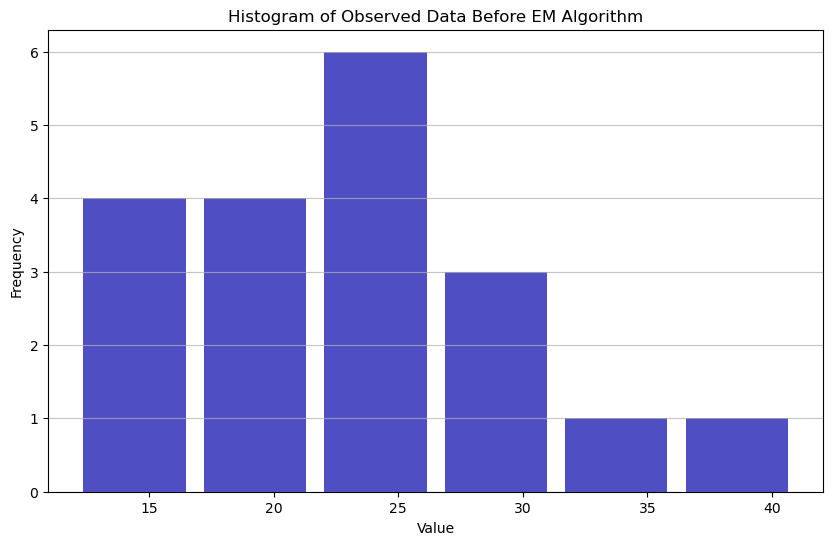

In [4]:
# Plot a histogram of the observed data before the EM algorithm
plt.figure(figsize=(10, 6))
plt.hist(obs_data, bins='auto', alpha=0.7, rwidth=0.85, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Observed Data Before EM Algorithm')
plt.show()

## EM Algorithm
### STEP 0 (Initialize)
Initialize true demand parameters to be average and standard deviation of the constrained data

In [5]:
# Initialization of true demand parameters
# We assume that the parameters for the unconstrained data are the same as the constrained
# We use the average and standard deviation as our initial parameters for the EM algorithm
# Assume the parameters for the unconstrained data is the same as the constrained
data_stats = stats.describe(obs_data)
mu0, sig0 = data_stats[2], math.sqrt(data_stats[3])
(mu0, sig0)

(22.526315789473685, 7.537818878846347)

### STEP 1 (E-step)
We replace the censored data by estimates of their uncensored values using the __current__ estimates of the mean and standard deviaiton.

Calculate the EV of the censored data in the log-likelihood function assuming they came from a normal distribution with parameters $(\mu^{(k-1)}, \sigma^{(k-1)})$.

What we want to calculate is the following:

Reference: https://en.wikipedia.org/wiki/Truncated_normal_distribution#Moments
Reference: https://stats.stackexchange.com/questions/166273/expected-value-of-x-in-a-normal-distribution-given-that-it-is-below-a-certain-v

A normal random variable(rv) $X$ with mean $\mu$ and standard deviation $\sigma$ has the same distribution as $\sigma Z+\mu$ where $Z$ is standard normal rv with mean 0 and standrad deviaiton of 1. Several special properties of $Z$:
- Its cdf is denoted by $\Phi$,
- It has pdf $\phi(z)=\Phi^\prime(z)$,
- $\phi^\prime(z)=-z\phi(z)$.

The third property can be derived easily using the pdf of a standard normal distribution.

Let the rv of interest be $X$. We define standard normal rv as $Z$:
$$Z = \dfrac{X-\mu}{\sigma}$$

Thus, for a certain value of $X$, let's say $C$, we have a corresponding $Z$ value as $c=\dfrac{C-\mu}{\sigma}$ and
$$Pr(X\leq C) = Pr(Z\leq c)=\Phi(c)$$
or, equivalently
$$Pr(X\geq C) = Pr(Z\geq c)=1-\Phi(c)$$

Now let's try to calculate the conditional expectation that we will use in E-step:
$$
E(X|X\geq C) = E(\sigma Z+\mu|Z\geq c)=\sigma E(Z|Z\geq c)+\mu E(1|Z\geq c)=\dfrac{\sigma \int_c^\infty z\phi(z)\,dz+\mu\int_c^\infty \phi(z)\,dz}{Pr(Z\geq c)}
=\dfrac{-\sigma \int_c^\infty \phi^\prime(z)\,dz+\mu\int_c^\infty\Phi^\prime(z)}{1-\Phi(c)} = \dfrac{-\sigma[\phi(\infty)-\phi(c)]+\mu[\Phi(\infty)-\Phi(c)]}{1-\Phi(c)}
=\dfrac{-\sigma[0-\phi(c)]+\mu[1-\Phi(c)]}{1-\Phi(c)} = \mu-\sigma\dfrac{-\phi(c)}{1-\Phi(c)} = \mu +\sigma\dfrac{\phi(c)}{1-\Phi(c)}
$$

### STEP 2 (M-step)
This step involves maximizing complete-data log likelihood function with respect to $\mu$ and $\sigma$. There are two critical points:
- The complete-data refers to the updated data where constrained points are replaced with the estimation in the E-step.
- $\mu$ and $\sigma$ are also updated values for the complete data with constrained values are repalced with their estimations.

It turns out the new $\mu$ and $\sigma$ are the average and standard deviation of the new complete-data. Once we have these updated parameters, we iterate E-step and M-step through until the convergence test is satisfied.

In [6]:
# Implementation of the EM algorithm
# We first make a copy of the observed data to avoid modifying the original data
# We then set our initial mu and sigma values
# We define a tolerance level and maximum number of iterations for our algorithm
# In the E-step, we replace the censored data by estimates of their uncensored values using the current parameters
# In the M-step, we update our parameters using the complete data from the E-step
obs_data_em = obs_data.copy()
mu_em = mu0
sig_em = sig0

# tolerance level and maximum iterations for the EM algorithm.
# They specify convergence/stop criteria
tol = 0.01
max_iter = 100

iteration = 0
mu_diff, sig_diff = 1, 1

# STOP if (abs(mu_k - mu_k_minus_1)<tol and abs(sig_k - sig_k_minus_1)<tol) or iteration > max_iteration
while not((mu_diff < tol and sig_diff < tol) or iteration > max_iter):
    data_update = []
    mu1 = mu_em
    sig1 = sig_em
    for idx, obs in enumerate(obs_data_em):
        if np.isin(idx, cons_data_index):
            # Standardized value of the booking limit
            bk_limit_stdr = (obs_data[idx] - mu1) / sig1
            # calculate expected value given the demand is greater than or equal to booking limit
            cons_obs_update = mu1 + sig1 * norm.pdf(bk_limit_stdr) / (1 - norm.cdf(bk_limit_stdr))
            data_update.append(cons_obs_update)
        else:
            # not constrained data points stay the same
            data_update.append(obs_data[idx])
    obs_data_em = np.array(data_update)
    mu_em, sig_em = stats.describe(obs_data_em)[2], math.sqrt(stats.describe(obs_data_em)[3])
    print(mu_em, sig_em)
    mu_diff, sig_diff = np.absolute(mu_em - mu1), np.absolute(sig_em - sig1)
    iteration += 1

print(iteration)

23.811902812062755 7.264223809564335
23.892377124041108 7.288780223314073
23.902349847735717 7.292585075554648
3


In [8]:
# Displaying the updated observed data
# This data reflects the changes made by the EM algorithm
obs_data_em

array([22.        , 15.        , 26.13861052, 33.        , 16.        ,
       28.55923652, 22.        , 25.44680007, 22.        , 17.        ,
       23.        , 19.        , 31.        , 17.        , 30.        ,
       23.        , 31.        , 12.        , 41.        ])

In [9]:
# Displaying statistical description of the updated observed data
# This provides a summary of the central tendency, dispersion and shape of the dataset’s distribution
stats.describe(obs_data_em)

DescribeResult(nobs=19, minmax=(12.0, 41.0), mean=23.902349847735717, variance=53.18179708420239, skewness=0.4600626229055299, kurtosis=-0.20768001760575583)

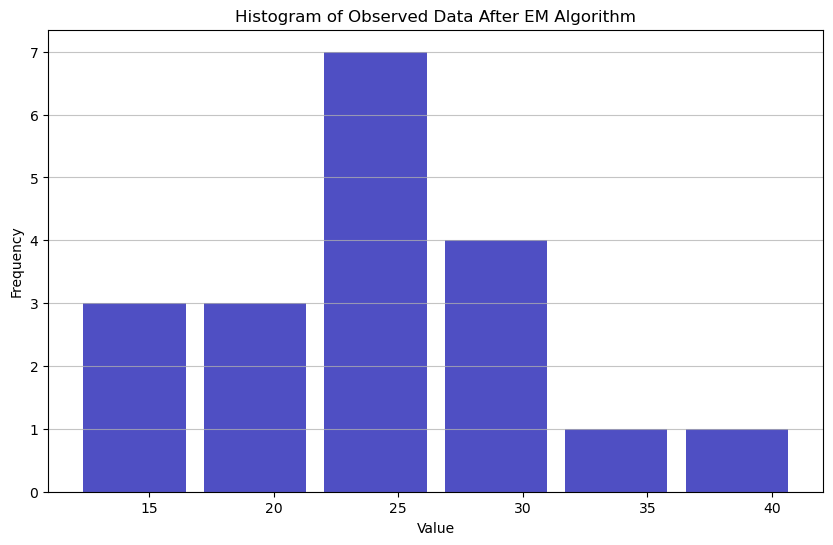

In [10]:
# Plot a histogram of the observed data after the EM algorithm
plt.figure(figsize=(10, 6))
plt.hist(obs_data_em, bins='auto', alpha=0.7, rwidth=0.85, color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Observed Data After EM Algorithm')
plt.show()

# Conclusion

In this notebook, we have implemented the Expectation-Maximization (EM) algorithm to correct for constrained capacity in demand forecasting. We began with a synthetic dataset of bookings, where some days were considered constrained. 

Using the EM algorithm, we were able to estimate the uncensored demand values and update the observed data accordingly. The histograms before and after applying the EM algorithm provide a clear visual illustration of how the data distribution changes.

The statistical description of the updated observed data gives us a summary of the central tendency, dispersion, and shape of the dataset's distribution. By comparing these statistics before and after applying the EM algorithm, we can quantify the changes brought about by the algorithm.

The EM algorithm provides a powerful method for dealing with censored or missing data, and this notebook demonstrates its application in a demand forecasting context.